In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import special
from scipy.optimize import fsolve

from tqdm.auto import tqdm
from scipy.sparse import coo_matrix, kron

# Advection Equation

## Periodic Boundary Condition
\begin{equation}\displaystyle
    \begin{cases}
        u_t - u_{xx} = 0, \text{ for } x\in [0,L], t\geq 0, \\
        u(0+x,t)=u(L+x,t)=0, t\geq 0, \\
        u(x,0)=f(x), \text{ for } x\in[0,L].
    \end{cases}
\end{equation}

## Dirichlet 
\begin{equation}\displaystyle
    \begin{cases}
        u_t - u_{xx} = 0, \text{ for } x\in [0,L], t\geq 0, \\
        u(x,t)=u(x,t)=0, t\geq 0, \\
        u(x,0)=f(x), \text{ for } x\in[0,L].
    \end{cases}
\end{equation}


## Neumann 
\begin{equation}\displaystyle
    \begin{cases}
        u_t - u_{xx} = 0, \text{ for } x\in [0,L], t\geq 0, \\
        u_x(x,t)=u_x(x,t)=0, t\geq 0, \\
        u(x,0)=f(x), \text{ for } x\in[0,L].
    \end{cases}
\end{equation}

In [111]:
x_left = 0
x_right = 1

t_left = 0
t_right = 1

Nx = pow(2,3) # number of spatial nodes
Nt = pow(2,8) # number of temporal nodes
step_h = 1/(Nx-1)
step_t = 1/(Nt-1)
max_iter = 2**5


x = np.linspace(x_left, x_right, Nx) # space domain
t = np.linspace(t_left, t_right, Nt) # time domain


# 
step_ratio = step_t / (step_h**2) # step ratio

class AdvectionEquation1D:
    def __init__(self, x_left, x_right, t_left, t_right,
                 Nx, Nt, bdy_cond):
        self.x_left = x_left
        self.x_right = x_right
        self.t_left = t_left
        self.t_right = t_right
        self.step_h = 1 / (Nx-1)
        self.step_t = 1 / (Nt-1)
        self.bdy_cond = bdy_cond
        
        self.step_ratio = self.step_t / (self.step_h**2)

    def checkStability(self):
        if self.step_ratio <= 1/2:
            return True
        else:
            return False

    def difference_matrix(self, N):
        I = np.eye(N)
        row = np.arange(1, N)
        col = np.arange(0, N-1)
        data = np.ones(N-1)
        off_diag = coo_matrix((data, (row, col)), shape=(N, N))
    
        off_diag = off_diag+off_diag.T
        self.A = off_diag - (np.eye(N) - step_ratio* np.eye(N))

    def exact_solution(self, x, t):
        return (np.exp(-np.power(np.pi,2)*t)) * np.sin(np.pi*x)

    def inital_condition(self, x):
        u = np.sin(np.pi*x)
        if self.bdy_cond == "Dirichlet":
            u[0] = u[-1] = 0
        return u

    def solve(self, u):
        return np.dot(self.A, u)

In [116]:
# def exact_solution(x, t):
#     return np.sin(x + t)
AE = AdvectionEquation1D(x_left, x_right, t_left, t_right, Nx, Nt, "Dirichlet")

u = np.zeros((Nx, Nt))
exact_u = np.zeros((Nx,Nt))
i = 0
eps = 0.001
error = 10**9
u[:, 0] = AE.inital_condition(x)
exact_u[:, 0] = AE.exact_solution(x, 0)


AE.difference_matrix(Nx-1)

for i in range(1, Nt):
    u[:, i] = AE.solve(u[:,i-1])
    exact_u[:, i] = AE.exact_solution(x,i*step_t)

ValueError: shapes (7,7) and (8,) not aligned: 7 (dim 1) != 8 (dim 0)

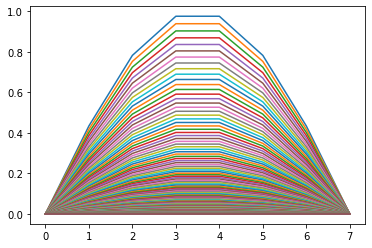

In [109]:
plt.plot(exact_u)
plt.show()

In [103]:
a = exact_u -u

In [115]:
x

array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        ])